In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime as dt
from pylab import rcParams
from sklearn.model_selection import train_test_split


# Incarcarea bazei de date
dataset_train = pd.read_csv('NVDA.csv', index_col='Date', parse_dates=True)

Y_train = dataset_train.sort_index().iloc[:4776][['Close']]
Y_test = dataset_train.sort_index().iloc[4777:][['Close']]

# Ne asiguram ca avem un pret de inchidere al activului financiar
assert 'Close' in dataset_train.columns, "'Close' column is missing in dataset_train"

# Scalarea datelor
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_train_scaled = scaler.fit_transform(Y_train)

# Convertirea datelor scalate intr-un nou DataFrame
dataset_train_scaled = pd.DataFrame(dataset_train_scaled, index=Y_train.index, columns=['Close'])


# Verificarea noului DataFrame
print(dataset_train_scaled.head())


               Close
Date                
1999-01-22  0.001239
1999-01-25  0.002011
1999-01-26  0.001380
1999-01-27  0.001356
1999-01-28  0.001333


# Crearea unui modelului de training folosind un model de tip LSTM (long short-term memory)

# Train

In [2]:
# Importam librariile necesare
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import numpy as np

# Crearea modelului secvential (folosim pretul de inchidere a 180 de zile trecute pentru a prezice pretul de inchidere pentru 30 de zile viitoare)
n_future = 5
n_past = 20

X_train = []
y_train = []

for i in range(n_past, len(dataset_train_scaled) - n_future):
    X_train.append(dataset_train_scaled.iloc[i - n_past:i].values)
    y_train.append(dataset_train_scaled.iloc[i + n_future - 1].values)

X_train, y_train = np.array(X_train), np.array(y_train)

# Definirea modelului
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, 1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))

# Compilarea modelului
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Antrenarea modelului
model.fit(X_train, y_train, epochs=10, batch_size=32)




Epoch 1/10


D:\Tools\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0052
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 9/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 10/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6397e-04


In [3]:
n_future

5

In [4]:
# Prezicerea pretului de inchidere viitor
future_predictions = []
current_batch = dataset_train_scaled[-n_past:].values.reshape((1, n_past, 1))

for i in range(n_future):
    future_pred = model.predict(current_batch)[0]
    future_predictions.append(future_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[future_pred]], axis=1)

# Convertim predictiile intr-un nou DataFrame
future_dates = pd.date_range(start=Y_train.index[-1], periods=n_future + 1, inclusive='right')
PREDICTIONS_FUTURE = pd.DataFrame(scaler.inverse_transform(future_predictions), index=future_dates, columns=['Close'])

# Rescalam datele de training la valorile originale
# Convert training predictions back to original scale
PREDICTION_TRAIN = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)), index=Y_train.index[n_past:len(X_train) + n_past], columns=['Close'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [5]:
dataset_train_scaled['Close'].tail()

Date
2018-01-08    0.990661
2018-01-09    0.990391
2018-01-10    0.998204
2018-01-11    1.000000
2018-01-12    0.995061
Name: Close, dtype: float64

Calcularea diferentelor dintre setul de train si setul real

In [6]:
PREDICTIONS_FUTURE

,Close
2018-01-13,55.446831
2018-01-14,55.280337
2018-01-15,55.137822
2018-01-16,55.027630
2018-01-17,54.943023


In [7]:
# Extragem pretul din setul real si il aliniem sa fie in acelasi range ca cel din setul de train
# Extract the actual stock prices for the same range as PREDICTION_TRAIN
ACTUAL_TRAIN = Y_train['Close'].iloc[n_past:len(X_train) + n_past]
#Dates = dates_2['Date'].iloc[n_past:len(X_train) + n_past]


# Ne asiguram ca data este aliniata coresounzator
ACTUAL_TRAIN.index = PREDICTION_TRAIN.index

# Calculam diferentele dintre pretul real si pretul prezis
DIFFERENCES_TRAIN = ACTUAL_TRAIN - PREDICTION_TRAIN['Close']

# Converitm noua variabila intr-un Data Frame nou
# Convert the differences to a DataFrame with the same index as the original data
DIFFERENCES_TRAIN_DF = pd.DataFrame({'Pret actual': ACTUAL_TRAIN, 'Pret Train': PREDICTION_TRAIN['Close'], 'Training Price vs. Actual price': DIFFERENCES_TRAIN})

# Verificarea rezultatelor
print(DIFFERENCES_TRAIN_DF)

            Pret actual  Pret Train  Training Price vs. Actual price
Date                                                                
1999-02-22     0.437500    0.919444                        -0.481944
1999-02-23     0.458333    0.925815                        -0.467482
1999-02-24     0.494792    0.939264                        -0.444472
1999-02-25     0.479167    0.964727                        -0.485560
1999-02-26     0.457031    0.979228                        -0.522197
...                 ...         ...                              ...
2017-12-29    48.375000   50.294189                        -1.919189
2018-01-02    49.837502   49.833282                         0.004220
2018-01-03    53.117500   50.295799                         2.821701
2018-01-04    53.397499   52.181549                         1.215950
2018-01-05    53.849998   53.213551                         0.636447

[4751 rows x 3 columns]


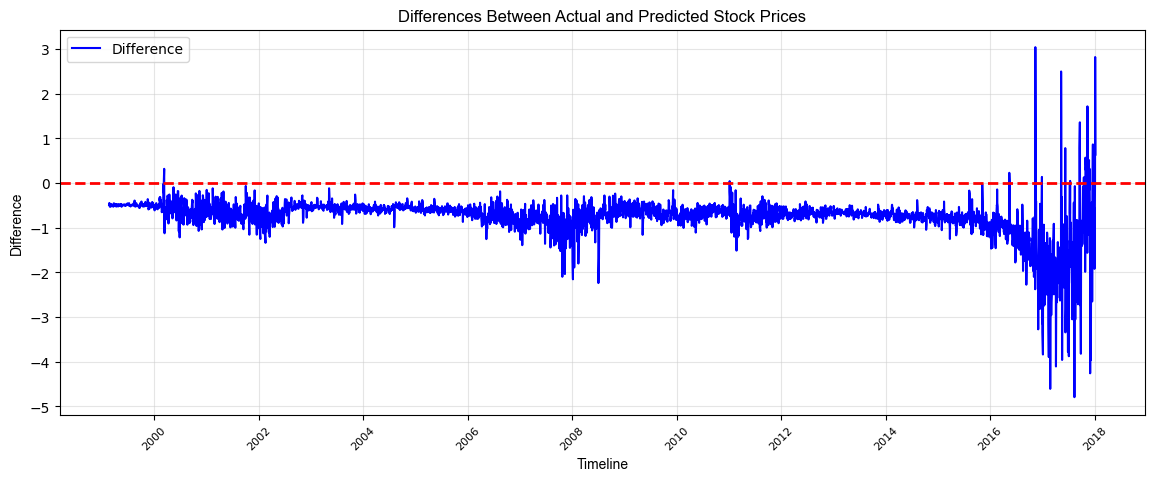

In [8]:
import matplotlib.pyplot as plt

# Create a DataFrame with the actual prices, predicted prices, and differences
DIFFERENCES_TRAIN_DF = pd.DataFrame({
    'Pret actual': ACTUAL_TRAIN,
    'Pret Train': PREDICTION_TRAIN['Close'],
    'Difference': DIFFERENCES_TRAIN
})


# Plot the differences
plt.figure(figsize=(14, 5))
plt.plot(DIFFERENCES_TRAIN_DF.index, DIFFERENCES_TRAIN_DF['Difference'], label='Difference', color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=2)

# Set plot parameters
plt.title('Differences Between Actual and Predicted Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Difference', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.grid(which='major', color='#cccccc', alpha=0.5)
plt.legend()
plt.show()

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import ttest_rel

# Assuming DIFFERENCES_TRAIN_DF is already created
# Extract the actual and predicted values
actual_values = DIFFERENCES_TRAIN_DF['Pret actual']
predicted_values = DIFFERENCES_TRAIN_DF['Pret Train']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(actual_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared
r2 = r2_score(actual_values, predicted_values)
print(f"R-squared (R²): {r2}")

# Perform paired t-test
t_stat, p_value = ttest_rel(actual_values, predicted_values)
print(f"Paired t-test: t-statistic = {t_stat}, p-value = {p_value}")


Mean Absolute Error (MAE): 0.7581720498790857
Mean Squared Error (MSE): 0.730775371878092
Root Mean Squared Error (RMSE): 0.8548540061777169
Mean Absolute Percentage Error (MAPE): 25.64202232721136%
R-squared (R²): 0.9898805508284911
Paired t-test: t-statistic = -125.50796414494842, p-value = 0.0


# Test

In [10]:


scaler1 = MinMaxScaler(feature_range=(0, 1))
dataset_train_scaled = scaler1.fit_transform(Y_test)

dataset_train_scaled = pd.DataFrame(dataset_train_scaled, index=Y_test.index, columns=['Close'])

X_test = []
y_test = []

for i in range(n_past, len(dataset_train_scaled) - n_future):
    X_test.append(dataset_train_scaled.iloc[i - n_past:i].values)
    y_test.append(dataset_train_scaled.iloc[i + n_future - 1].values)
# Convertirea datelor scalate intr-un nou DataFrame
X_test, y_test = np.array(X_test), np.array(y_test)

future_predictions = []
current_batch = dataset_train_scaled[-n_past:].values.reshape((1, n_past, 1))

for i in range(n_future):
    future_pred = model.predict(current_batch)[0]
    future_predictions.append(future_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[future_pred]], axis=1)

# Convertim predictiile intr-un nou DataFrame
future_dates = pd.date_range(start=Y_test.index[-1], periods=n_future + 1, inclusive='right')
PREDICTIONS_FUTURE = pd.DataFrame(scaler.inverse_transform(future_predictions), index=future_dates, columns=['Close'])

# Rescalam datele de training la valorile originale
# Convert training predictions back to original scale
PREDICTION_TEST = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)), index=Y_test.index[n_past:len(X_test) + n_past], columns=['Close'])

# Extragem pretul din setul real si il aliniem sa fie in acelasi range ca cel din setul de train
# Extract the actual stock prices for the same range as PREDICTION_TRAIN
ACTUAL_TEST = Y_test['Close'].iloc[n_past:len(X_test) + n_past]
#Dates = dates_2['Date'].iloc[n_past:len(X_train) + n_past]


# Ne asiguram ca data este aliniata coresounzator
ACTUAL_TEST.index = PREDICTION_TEST.index

# Calculam diferentele dintre pretul real si pretul prezis
DIFFERENCES_TEST = ACTUAL_TEST - PREDICTION_TEST['Close']

# Converitm noua variabila intr-un Data Frame nou
# Convert the differences to a DataFrame with the same index as the original data
DIFFERENCES_TEST_DF = pd.DataFrame({'Pret actual': ACTUAL_TRAIN, 'Pret Train': PREDICTION_TRAIN['Close'], 'Training Price vs. Actual price': DIFFERENCES_TRAIN})

# Verificarea rezultatelor
print(DIFFERENCES_TEST_DF)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
            Pret actual  Pret Train  Training Price vs. Actual price
Date                                                                
1999-02-22     0.437500    0.919444                        -0.481944
1999-02-23     0.458333    0.925815                        -0.467482
1999-02-24     0.494792    0.939264                        -0.444472
1999-02-25     0.479167    0.964727                        -0.485560
1999-02-26     0.457031    0.979228                        -0.522197
...                 ...         ...                              ...
2017-12-29    48.375000   50.294189                        -1.919189
2018-01-02    49.837502   49.833282                         0.004220
2018-01-03    53.117500   50.295799                         2.821701
2018-01-04  

# Plotarea rezultatelor

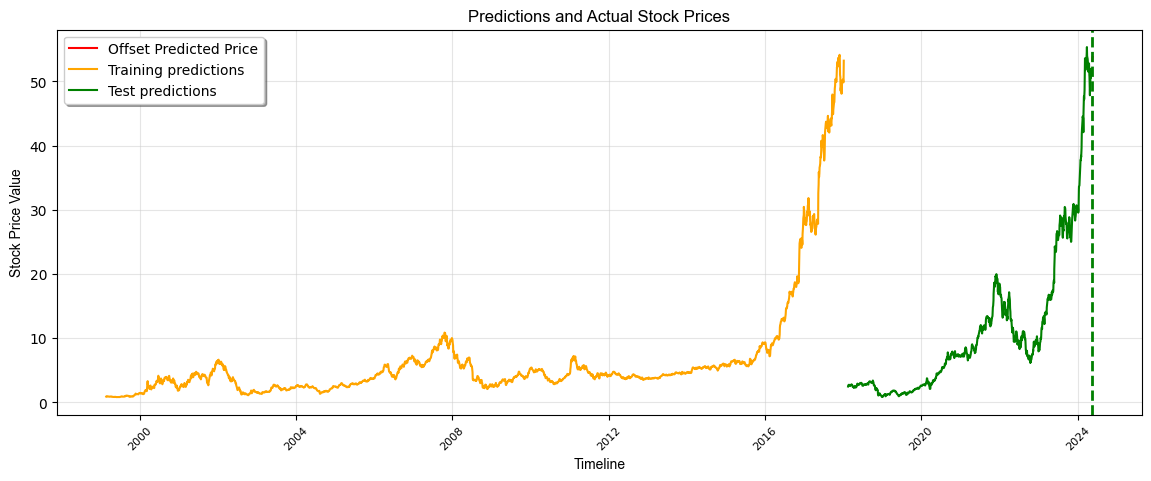

In [13]:
# Setam paramterii graficului
rcParams['figure.figsize'] = 14, 5

# Setarea unei date pentru inceputul graficului
START_DATE_FOR_PLOTTING = dt.datetime.strptime('2018-06-01', '%Y-%m-%d').date()

# Ne asiguram ca indecsii sunt de tip date
PREDICTIONS_FUTURE.index = pd.to_datetime(PREDICTIONS_FUTURE.index)
PREDICTION_TRAIN.index = pd.to_datetime(PREDICTION_TRAIN.index)
dataset_train.index = pd.to_datetime(dataset_train.index)

# Grafic
plt.figure(figsize=(14, 5))
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Close'], color='r', label='Offset Predicted Price')
plt.plot(PREDICTION_TRAIN.index, PREDICTION_TRAIN['Close'], color='orange', label='Training predictions')
plt.plot(PREDICTION_TEST.index, PREDICTION_TEST['Close'], color='green', label='Test predictions')
#plt.plot(dataset_train.index, dataset_train['Close'], color='b', label='Actual Stock Price')

plt.axvline(x=min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()


Dataset Train Date Range: 1999-01-22 00:00:00 to 2024-05-13 00:00:00
Prediction Train Date Range: 1999-02-22 00:00:00 to 2018-01-05 00:00:00
Predictions Future Date Range: 2024-05-14 00:00:00 to 2024-05-18 00:00:00


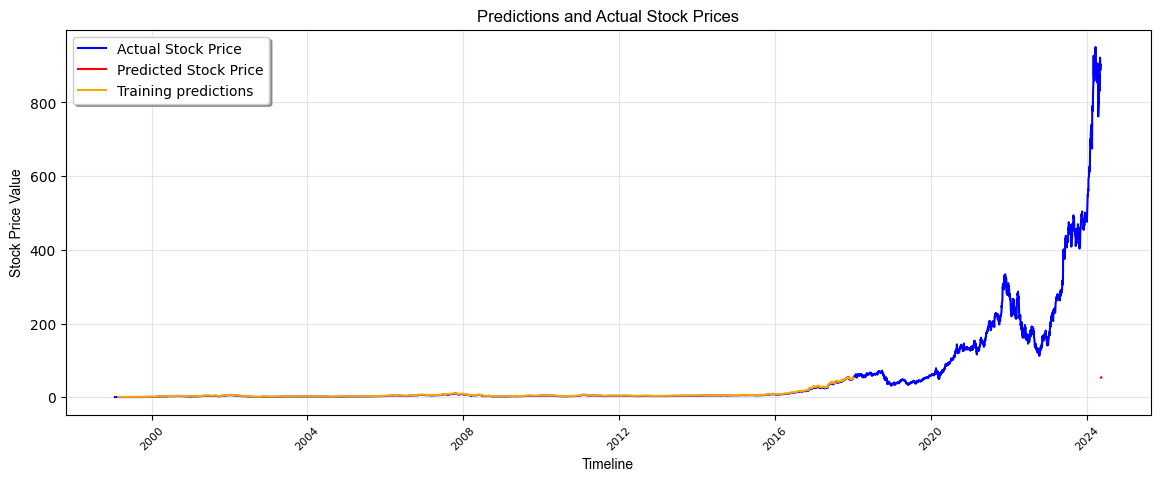

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime as dt

# Ensure START_DATE_FOR_PLOTTING is a pd.Timestamp
START_DATE_FOR_PLOTTING = pd.Timestamp(dt.datetime.strptime('2012-06-01', '%Y-%m-%d').date())

# Check the date range for dataset_train, PREDICTION_TRAIN, and PREDICTIONS_FUTURE
print("Dataset Train Date Range:", dataset_train.index.min(), "to", dataset_train.index.max())
print("Prediction Train Date Range:", PREDICTION_TRAIN.index.min(), "to", PREDICTION_TRAIN.index.max())
print("Predictions Future Date Range:", PREDICTIONS_FUTURE.index.min(), "to", PREDICTIONS_FUTURE.index.max())

# Ensure START_DATE_FOR_PLOTTING is within the range of dataset_train
START_DATE_FOR_PLOTTING = max(START_DATE_FOR_PLOTTING, dataset_train.index.min())

# Plot parameters
rcParams['figure.figsize'] = 14, 5

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(dataset_train.index, dataset_train['Close'], color='b', label='Actual Stock Price')
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Close'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.index, PREDICTION_TRAIN['Close'], color='orange', label='Training predictions')


#plt.axvline(x=min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()
